# **Cheminformatics in Python: Predicting Solubility of Molecules** 


## Acknowledgment

**The idea and most of the code is adapted from the the work of [Chanin Nantasenamat](https://github.com/dataprofessor/code/blob/master/python/cheminformatics_predicting_solubility.ipynb).**



We will be reproducing a research article (by John S. Delaney$^1$) and use it in Lipophilicity dataset.

## **1. Install rdkit**

In [ ]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [ ]:
! wget https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/Lipophilicity.csv

--2020-12-07 10:03:12--  https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/Lipophilicity.csv
Resolving deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)... 52.219.112.209
Connecting to deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)|52.219.112.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 282606 (276K) [text/csv]
Saving to: ‘Lipophilicity.csv’

Lipophilicity.csv   100%[===================>] 275.98K   962KB/s    in 0.3s    

2020-12-07 10:03:12 (962 KB/s) - ‘Lipophilicity.csv’ saved [282606/282606]



### **Read in the dataset**

In [ ]:
import pandas as pd

In [ ]:
sol = pd.read_csv('Lipophilicity.csv')
sol

,CMPD_CHEMBLID,exp,smiles
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...
...,...,...,...
4195,CHEMBL496929,3.85,OCCc1ccc(NC(=O)c2cc3cc(Cl)ccc3[nH]2)cc1
4196,CHEMBL199147,3.21,CCN(C1CCN(CCC(c2ccc(F)cc2)c3ccc(F)cc3)CC1)C(=O...
4197,CHEMBL15932,2.10,COc1cccc2[nH]ncc12
4198,CHEMBL558748,2.65,Clc1ccc2ncccc2c1C(=O)NCC3CCCCC3


In [ ]:
sol.rename(columns={'CMPD_CHEMBLID':'CMPD_CHEMBLID', "exp": "logD","smiles": "SMILES"}, inplace=True)

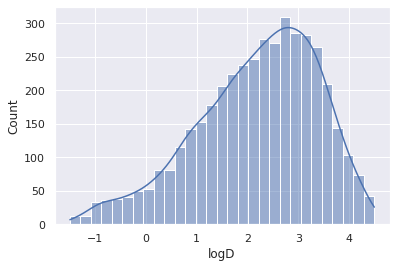

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
import seaborn as sns
sns.set()
%matplotlib inline

sns.histplot(sol.logD,kde=True);

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
import seaborn as sns
sns.set()
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Lipophi_canon.csv")
df.head()

,CMPD_CHEMBLID,exp,smiles,canonical_smiles
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14,Cn1c(CN2CCN(c3ccc(Cl)cc3)CC2)nc2ccccc21
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...,COc1cc(OC)c(S(=O)(=O)N2c3ccccc3CCC2C)cc1NC(=O)...
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl,COC(=O)[C@H](c1ccccc1Cl)N1CCc2sccc2C1
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...,O=C(NC1Cc2ccccc2N(C[C@@H](O)CO)C1=O)c1cc2cc(Cl...
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...,Cc1cccc(C[C@H](NC(=O)c2cc(C(C)(C)C)nn2C)C(=O)N...


In [ ]:
df.rename(columns={'CMPD_CHEMBLID':'CMPD_CHEMBLID', "exp": "logD",
                   "smiles": "smiles","canonical_smiles":"SMILES"}, inplace=True)

df = df.drop(['CMPD_CHEMBLID', 'smiles'], axis=1)

In [ ]:
df.head()

,logD,SMILES
0,3.54,Cn1c(CN2CCN(c3ccc(Cl)cc3)CC2)nc2ccccc21
1,-1.18,COc1cc(OC)c(S(=O)(=O)N2c3ccccc3CCC2C)cc1NC(=O)...
2,3.69,COC(=O)[C@H](c1ccccc1Cl)N1CCc2sccc2C1
3,3.37,O=C(NC1Cc2ccccc2N(C[C@@H](O)CO)C1=O)c1cc2cc(Cl...
4,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(C(C)(C)C)nn2C)C(=O)N...


In [ ]:
df.shape

(4200, 2)

# Calculate molecular descriptors**

To predict **LogS** (log of the aqueous solubility), the study by Delaney makes use of 4 molecular descriptors:
1. **cLogP** *(Octanol-water partition coefficient)*
2. **MW** *(Molecular weight)*
3. **RB** *(Number of rotatable bonds)*
4. **AP** *(Aromatic proportion = number of aromatic atoms / total number of heavy atoms)*

Unfortunately, rdkit readily computes the first 3. As for the AP descriptor, we will calculate this by manually computing the ratio of the *number of aromatic atoms* to the *total number of heavy atoms* which rdkit can compute.

In [ ]:
# import numpy as np
# import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors

In [ ]:
def AromaticProportion(m): 
  #source https://github.com/dataprofessor/code/blob/master/python/cheminformatics_predicting_solubility.ipynb
  aromatic_atoms = [m.GetAtomWithIdx(i).GetIsAromatic() for i in range(m.GetNumAtoms())]
  aa_count = []
  for i in aromatic_atoms:
    if i==True:
      aa_count.append(1)
  AromaticAtom = sum(aa_count)  # Number of aromatic atoms
  HeavyAtom = Descriptors.HeavyAtomCount(m) #Number of heavy atoms
  AR = AromaticAtom/HeavyAtom
  return AR
  
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def generate(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_MolWt = Descriptors.MolWt(mol)
        desc_NumRotatableBonds = Descriptors.NumRotatableBonds(mol)
        desc_AromaticProportion = AromaticProportion(mol)
           
        row = np.array([desc_MolLogP,
                        desc_MolWt,
                        desc_NumRotatableBonds,
                        desc_AromaticProportion])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MolLogP","MolWt","NumRotatableBonds","AromaticProportion"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [ ]:
sol = df

In [ ]:
X = generate(sol.SMILES)

In [ ]:
sol.head()

,logD,SMILES
0,3.54,Cn1c(CN2CCN(c3ccc(Cl)cc3)CC2)nc2ccccc21
1,-1.18,COc1cc(OC)c(S(=O)(=O)N2c3ccccc3CCC2C)cc1NC(=O)...
2,3.69,COC(=O)[C@H](c1ccccc1Cl)N1CCc2sccc2C1
3,3.37,O=C(NC1Cc2ccccc2N(C[C@@H](O)CO)C1=O)c1cc2cc(Cl...
4,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(C(C)(C)C)nn2C)C(=O)N...


Assigning the second column (index 1) to the Y matrix

In [ ]:
Y = sol.iloc[:,0]
Y

0       3.54
1      -1.18
2       3.69
3       3.37
4       3.10
        ... 
4195    3.85
4196    3.21
4197    2.10
4198    2.65
4199    2.70
Name: logD, Length: 4200, dtype: float64

## **Data split**

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

## **Random Forest Regressor Model**

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor
import time
tic = time.perf_counter()
model = RandomForestRegressor()
model.fit(X_train, Y_train)

### **Test on  X_test**

In [ ]:
Y_pred_test = model.predict(X_test)

In [ ]:
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_test, Y_pred_test))

Mean squared error (MSE): 0.97


In [ ]:
np.sqrt(mean_squared_error(Y_test, Y_pred_test))

0.9872430080713858

In [ ]:
RMSElist = []
for i in range(10):
    model = RandomForestRegressor(random_state=i+5)
    model.fit(X_train, Y_train)
    Y_pred_test = model.predict(X_test)
    RMSElist.append(np.sqrt(mean_squared_error(Y_test, Y_pred_test)))

In [ ]:
np.mean(RMSElist),np.std(RMSElist)

(0.9832456191907232, 0.004860381510658169)

RMSE = $0.983 \pm  0.01$

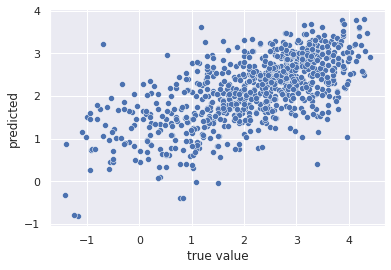

In [ ]:
p = sns.scatterplot(x=Y_test, y=Y_pred_test)
p.set(xlabel='true value', ylabel='predicted')
plt.show()

In [ ]:
df_res = pd.DataFrame({"RMSE":RMSElist, "model":'RF'})
df_res2 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/RMSE_ULMFiT.csv')
df_RMSE = pd.concat([df_res,df_res2])

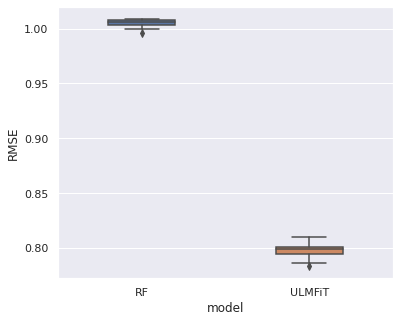

In [ ]:
plt.figure(figsize=(6,5))
ax = sns.boxplot(x="model", y="RMSE", data=df_RMSE,width=0.4);
plt.show();

## **Reference**

[1] John S. Delaney. [ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure](https://pubs.acs.org/doi/10.1021/ci034243x). ***J. Chem. Inf. Comput. Sci.*** 2004, 44, 3, 1000-1005.

[2] Pat Walters. [Predicting Aqueous Solubility - It's Harder Than It Looks](http://practicalcheminformatics.blogspot.com/2018/09/predicting-aqueous-solubility-its.html). ***Practical Cheminformatics Blog***

[3] Bharath Ramsundar, Peter Eastman, Patrick Walters, and Vijay Pande. [Deep Learning for the Life Sciences: Applying Deep Learning to Genomics, Microscopy, Drug Discovery, and More](https://learning.oreilly.com/library/view/deep-learning-for/9781492039822/), O'Reilly, 2019.

[4] [Supplementary file](https://pubs.acs.org/doi/10.1021/ci034243x) from Delaney's ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure.